In [54]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [55]:
num_epochs = 100
batch_size = 100
learning_rate = 1e-3
reg_lmbd = 1e-4

In [56]:
train_dataset = dsets.MNIST(root='data/', 
                            train=True, 
                            transform=transforms.ToTensor(),  
                            download=True)
test_dataset = dsets.MNIST(root='data/', 
                           train=False, 
                           transform=transforms.ToTensor())

In [57]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [58]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [59]:
class ContractiveAutoencoder(nn.Module):
    def __init__(self):
        super(ContractiveAutoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784,400,bias=False),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(400,784),
            nn.Sigmoid()
        )
        
    def forward(self,x):
        x = self.encoder(x)
        out = self.decoder(x)
        return x,out

In [60]:
# Implementation reference - https://wiseodd.github.io/techblog/2016/12/05/contractive-autoencoder/

class ContractiveAELoss(nn.Module):
    def __init__(self,lmbd):
        super(ContractiveAELoss,self).__init__()
        self.bceloss = nn.BCELoss()
        self.lmbd = lmbd

    def forward(self,targets,actual,weights,hidden_op):
        loss_bce  = self.bceloss(targets,actual)
        dh = hidden_op * (1-hidden_op)
        w_sum = torch.sum(weights ** 2,dim=1)
        #print(w_sum.size())
        w_sum = w_sum.unsqueeze(1)
        #print(w_sum.size())
        contractive_loss = torch.sum(torch.mm(dh**2, w_sum), 0)
        total_loss = loss_bce + contractive_loss.mul_(self.lmbd)
        return total_loss

In [61]:
model = ContractiveAutoencoder()

In [62]:
model

ContractiveAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=False)
    (1): ReLU(inplace)
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [63]:
model.state_dict()

OrderedDict([('encoder.0.weight',
              tensor([[ 2.0781e-02,  3.3058e-03, -7.4142e-03,  ..., -2.8297e-02,
                       -2.8479e-02,  2.1977e-02],
                      [ 2.7651e-02, -1.9840e-02, -1.8380e-02,  ..., -8.3144e-03,
                        1.9902e-02,  3.5028e-02],
                      [-2.8927e-02,  2.8389e-02, -1.1021e-02,  ...,  2.6231e-03,
                       -1.9823e-02,  6.6733e-03],
                      ...,
                      [-8.4967e-03,  2.6137e-02,  2.1342e-02,  ..., -6.1755e-03,
                       -3.3788e-02,  2.3377e-03],
                      [ 1.3155e-02, -1.8176e-02,  2.9448e-02,  ...,  7.0226e-03,
                       -2.7186e-02, -8.6945e-03],
                      [-5.1170e-03, -2.8926e-02, -2.8630e-02,  ...,  3.0332e-02,
                       -2.6075e-02,  3.1407e-02]])),
             ('decoder.0.weight',
              tensor([[ 8.1783e-03, -3.9050e-02,  4.0053e-02,  ..., -2.4830e-02,
                        2.4144e-02,

In [64]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [65]:
criterion = ContractiveAELoss(reg_lmbd)

In [66]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Convert torch tensor to Variable
        images = images.view(-1, 28*28)
        optimizer.zero_grad()
        hidden_op,outputs = model(images)
        en_weights = model.state_dict()['encoder.0.weight']
        loss = criterion.forward(outputs, images,en_weights,hidden_op)
        #print(loss)
        loss.backward()
        optimizer.step()
        
        if((i+1) % 100 == 0):
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))

Epoch [1/100], Step [100/600], Loss: 0.2183
Epoch [1/100], Step [200/600], Loss: 0.1838
Epoch [1/100], Step [300/600], Loss: 0.1736
Epoch [1/100], Step [400/600], Loss: 0.1595
Epoch [1/100], Step [500/600], Loss: 0.1626
Epoch [1/100], Step [600/600], Loss: 0.1520
Epoch [2/100], Step [100/600], Loss: 0.1560
Epoch [2/100], Step [200/600], Loss: 0.1470
Epoch [2/100], Step [300/600], Loss: 0.1461
Epoch [2/100], Step [400/600], Loss: 0.1468
Epoch [2/100], Step [500/600], Loss: 0.1477
Epoch [2/100], Step [600/600], Loss: 0.1424
Epoch [3/100], Step [100/600], Loss: 0.1394
Epoch [3/100], Step [200/600], Loss: 0.1386
Epoch [3/100], Step [300/600], Loss: 0.1385
Epoch [3/100], Step [400/600], Loss: 0.1419
Epoch [3/100], Step [500/600], Loss: 0.1349
Epoch [3/100], Step [600/600], Loss: 0.1352
Epoch [4/100], Step [100/600], Loss: 0.1430
Epoch [4/100], Step [200/600], Loss: 0.1344
Epoch [4/100], Step [300/600], Loss: 0.1371
Epoch [4/100], Step [400/600], Loss: 0.1337
Epoch [4/100], Step [500/600], L

Epoch [31/100], Step [400/600], Loss: 0.1285
Epoch [31/100], Step [500/600], Loss: 0.1309
Epoch [31/100], Step [600/600], Loss: 0.1283
Epoch [32/100], Step [100/600], Loss: 0.1240
Epoch [32/100], Step [200/600], Loss: 0.1288
Epoch [32/100], Step [300/600], Loss: 0.1223
Epoch [32/100], Step [400/600], Loss: 0.1283
Epoch [32/100], Step [500/600], Loss: 0.1268
Epoch [32/100], Step [600/600], Loss: 0.1250
Epoch [33/100], Step [100/600], Loss: 0.1247
Epoch [33/100], Step [200/600], Loss: 0.1260
Epoch [33/100], Step [300/600], Loss: 0.1270
Epoch [33/100], Step [400/600], Loss: 0.1255
Epoch [33/100], Step [500/600], Loss: 0.1289
Epoch [33/100], Step [600/600], Loss: 0.1309
Epoch [34/100], Step [100/600], Loss: 0.1223
Epoch [34/100], Step [200/600], Loss: 0.1255
Epoch [34/100], Step [300/600], Loss: 0.1248
Epoch [34/100], Step [400/600], Loss: 0.1267
Epoch [34/100], Step [500/600], Loss: 0.1263
Epoch [34/100], Step [600/600], Loss: 0.1306
Epoch [35/100], Step [100/600], Loss: 0.1250
Epoch [35/

Epoch [61/100], Step [600/600], Loss: 0.1350
Epoch [62/100], Step [100/600], Loss: 0.1293
Epoch [62/100], Step [200/600], Loss: 0.1345
Epoch [62/100], Step [300/600], Loss: 0.1334
Epoch [62/100], Step [400/600], Loss: 0.1295
Epoch [62/100], Step [500/600], Loss: 0.1292
Epoch [62/100], Step [600/600], Loss: 0.1327
Epoch [63/100], Step [100/600], Loss: 0.1292
Epoch [63/100], Step [200/600], Loss: 0.1299
Epoch [63/100], Step [300/600], Loss: 0.1337
Epoch [63/100], Step [400/600], Loss: 0.1343
Epoch [63/100], Step [500/600], Loss: 0.1355
Epoch [63/100], Step [600/600], Loss: 0.1357
Epoch [64/100], Step [100/600], Loss: 0.1335
Epoch [64/100], Step [200/600], Loss: 0.1352
Epoch [64/100], Step [300/600], Loss: 0.1282
Epoch [64/100], Step [400/600], Loss: 0.1331
Epoch [64/100], Step [500/600], Loss: 0.1321
Epoch [64/100], Step [600/600], Loss: 0.1311
Epoch [65/100], Step [100/600], Loss: 0.1305
Epoch [65/100], Step [200/600], Loss: 0.1313
Epoch [65/100], Step [300/600], Loss: 0.1296
Epoch [65/

Epoch [92/100], Step [200/600], Loss: 0.1311
Epoch [92/100], Step [300/600], Loss: 0.1283
Epoch [92/100], Step [400/600], Loss: 0.1339
Epoch [92/100], Step [500/600], Loss: 0.1343
Epoch [92/100], Step [600/600], Loss: 0.1300
Epoch [93/100], Step [100/600], Loss: 0.1367
Epoch [93/100], Step [200/600], Loss: 0.1303
Epoch [93/100], Step [300/600], Loss: 0.1291
Epoch [93/100], Step [400/600], Loss: 0.1299
Epoch [93/100], Step [500/600], Loss: 0.1326
Epoch [93/100], Step [600/600], Loss: 0.1371
Epoch [94/100], Step [100/600], Loss: 0.1318
Epoch [94/100], Step [200/600], Loss: 0.1267
Epoch [94/100], Step [300/600], Loss: 0.1305
Epoch [94/100], Step [400/600], Loss: 0.1371
Epoch [94/100], Step [500/600], Loss: 0.1264
Epoch [94/100], Step [600/600], Loss: 0.1279
Epoch [95/100], Step [100/600], Loss: 0.1354
Epoch [95/100], Step [200/600], Loss: 0.1295
Epoch [95/100], Step [300/600], Loss: 0.1331
Epoch [95/100], Step [400/600], Loss: 0.1371
Epoch [95/100], Step [500/600], Loss: 0.1309
Epoch [95/

In [101]:
def validate_op(n_images,orig_images,decoded_images,image_width):
    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    plt.ylabel("Decoded (Bottom)   |   Original(Top)")
    orig_images = orig_images[:n_images]
    decoded_images = decoded_images[:n_images]
    
    
    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            ax[i].imshow(img[i].detach().reshape((image_width, image_width)),cmap = 'gray')

In [81]:
test_images,_ = next(iter(test_loader))

In [82]:
_,test_output = model(test_images.view(-1,28*28))
test_output =test_output.view(100,28,28)

C:\Users\mohit_tare\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


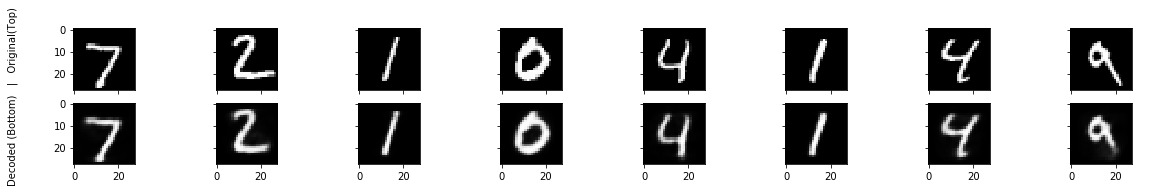

In [102]:
validate_op(8,test_images,test_output,28)